In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib.pyplot as plt

In [4]:
plt.style.use('presentation-dark.mplstyle')

In [5]:
from fitting_scripts import *

/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


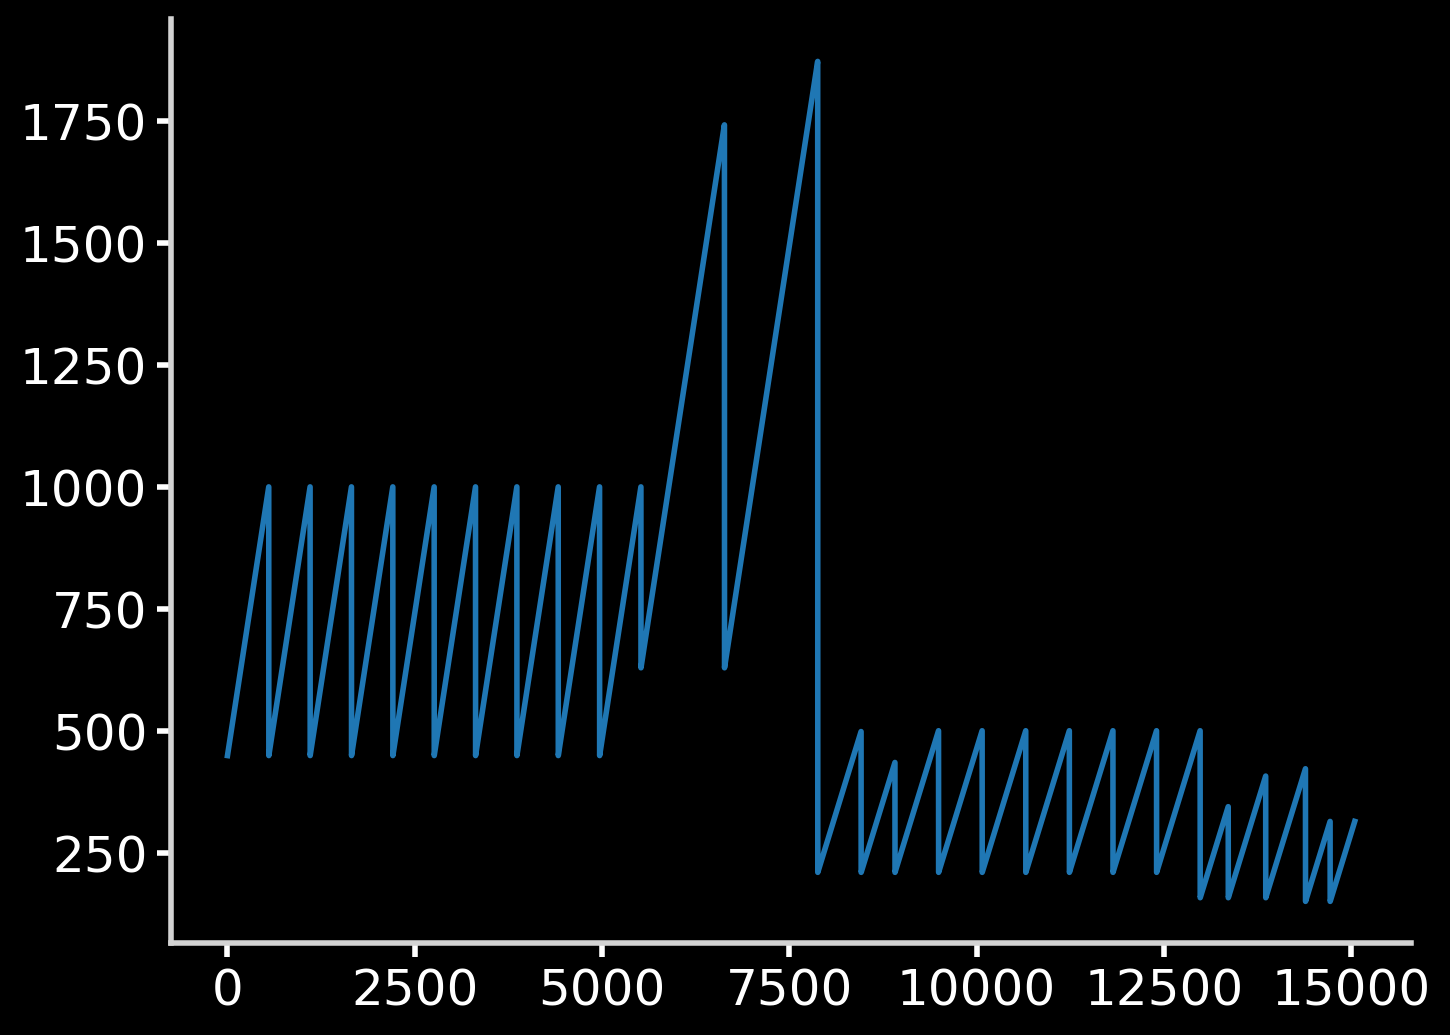

In [6]:
# "pt_df" is a pandas.DataFrame collecting relevant physical quantity time series from 
# all simulations into a long-form array
# it will not be straightforward to bundle each model's points from this data 
pt_df = pd.read_pickle('points_all.p')
pt_logdf = np.log10(pt_df)

# one can bundle data for each model based on "time_code" field 
# that is increasing within each model's data output
plt.plot(pt_df['time_code'])

In [7]:
# "qdset" is a xarray.Dataset storing the (16, 50, 84) percentile values and mean and std for each model's time series into an effectively 3D array.
with xr.open_dataarray('percentiles_all.nc') as qdset:
    # get median values and convert it into pandas.DataFrame
    mid_df = qdset.sel(q='50').to_dataset(dim='variable').drop('q').to_dataframe()
    mid_logdf = np.log10(mid_df)

/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


In [8]:
# these are all quantity name stored in this data
# we are mostly interested in fitting "Yxxx" as a function of "W" and "Zgas"
print(qdset['variable'])

<xarray.DataArray 'variable' (variable: 94)>
array(['Ptot', 'Ytot', 'Ptot_top', 'dPtot', 'Pturb', 'Yturb', 'Pturb_top',
       'dPturb', 'Pth', 'Yth', 'Pth_top', 'dPth', 'Pimag', 'Ymag', 'Pimag_top',
       'dPimag', 'oPimag', 'oYmag', 'oPimag_top', 'doPimag', 'dYmag',
       'dPimag_top', 'ddPimag', 'Prad', 'Yrad', 'Prad_top', 'dPrad',
       'Ptot_hot', 'Ytot_hot', 'Ptot_hot_top', 'dPtot_hot', 'Pturb_hot',
       'Yturb_hot', 'Pturb_hot_top', 'dPturb_hot', 'Pth_hot', 'Yth_hot',
       'Pth_hot_top', 'dPth_hot', 'Pimag_hot', 'Ymag_hot', 'Pimag_hot_top',
       'dPimag_hot', 'oPimag_hot', 'oYmag_hot', 'oPimag_hot_top',
       'doPimag_hot', 'dYmag_hot', 'dPimag_hot_top', 'ddPimag_hot', 'Prad_hot',
       'Yrad_hot', 'Prad_hot_top', 'dPrad_hot', 'Ynonth', 'nH',
       'sigma_eff_mid', 'sigma_eff', 'sigma_turb_mid', 'sigma_turb',
       'sigma_th_mid', 'sigma_th', 'H', 'PDE_whole_approx',
       'PDE_2p_avg_approx', 'PDE_2p_mid_approx', 'PDE_whole_full',
       'PDE_2p_avg_full', 'PDE_2p

# fitting with points 

In [9]:
from matplotlib.lines import Line2D

In [10]:
# We are fitting variables as a function of "W" and "Zgas"
# I set the parameter range of interest (in log scale) here
Zmin=-1.3
Zmax=0.3
Wmin=2.7
Wmax=6.3

In [11]:
# setup figure output directory
outdir = './lowZ-figures-talk/'
os.makedirs(outdir,exist_ok=True)

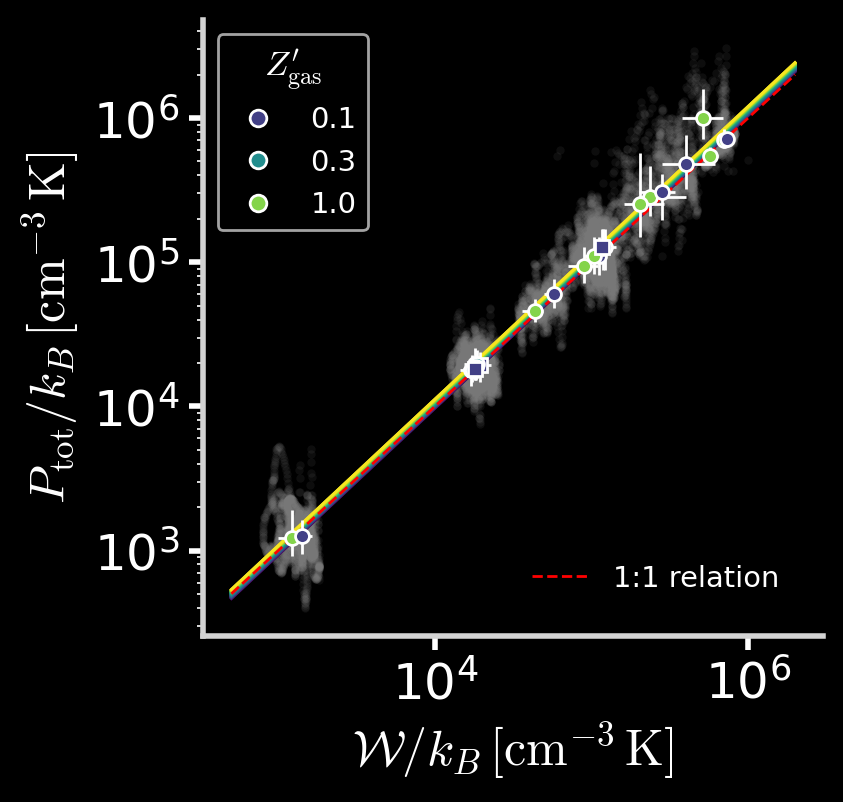

In [39]:
# Figure for weight and Ptot showing off parameter coverage
fig,ax = plt.subplots(1,1,figsize=(4,4))

# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1,x2,yf=['W','Zgas','Ptot']

# exclude bad values from the fit
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
# linear regression
regr = regress(pt_logdf,x1=x1,x2=x2,yf=yf,fit_intercept=True)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model(regr,Zmin=Zmin,Zmax=Zmax,Wmin=Wmin,Wmax=Wmax,dims=[x2,x1])    

# plot simulation data along with fitting result
plt.sca(ax)
# call plotting script
plot_fitting_points(qdset,model_dset,x1,yf,legend=2,colorbar=0,model=regr)
# plot all data as grey dots
plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)    

# plot one-to-one line
plt.plot(model_dset.W,model_dset.W,lw=1,ls='--',color='r')
# add custom legend
leg1=plt.gca().get_legend()
custom_lines2 = [Line2D([0], [0], ls = '--', color='r', lw=1)]
leg2 = plt.legend(custom_lines2,['1:1 relation'],loc=4,borderpad=1,fontsize='xx-small',frameon=False)
plt.gca().add_artist(leg1)

# # decorate axis
# fig.axes[-1].xaxis.set_ticks_position('top')
# fig.axes[-1].xaxis.set_label_position('top')
# plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
# fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')

# save figure
plt.savefig(os.path.join(outdir,'PW_fit.png'),bbox_inches='tight')

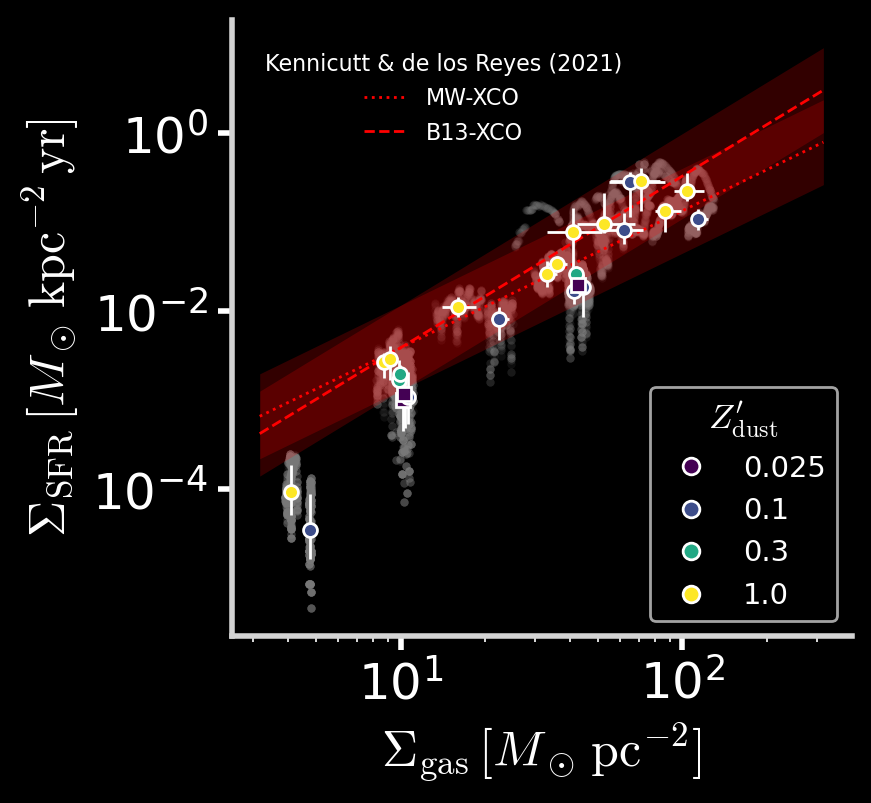

In [65]:
# Figure for weight and Ptot showing off parameter coverage
fig,ax = plt.subplots(1,1,figsize=(4,4))

# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1,x2,yf=['Sigma_gas','Zdust','sfr']

# exclude bad values from the fit
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
# linear regression
regr = regress(pt_logdf_good,x1=x1,x2=x2,yf=yf,fit_intercept=True)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model(regr,Zmin=Zmin,Zmax=0,Wmin=0.5,Wmax=2.5,dims=[x2,x1])    

# plot simulation data along with fitting result
plt.sca(ax)
# call plotting script
plot_fitting_points(qdset,model_dset,x1,yf,legend=4,colorbar=0,model=False)
# plot all data as grey dots
plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)    
Sigma=model_dset.Sigma_gas.data
KS_sfr1 = Sigma**1.54*10**(-3.95)
KS_sfr2 = Sigma**1.93*10**(-4.34)
plt.plot(Sigma,KS_sfr1,ls=':',color='r',lw=1)
plt.fill_between(Sigma,KS_sfr1/3,KS_sfr1*3,color='r',alpha=0.2,lw=0)
plt.plot(Sigma,KS_sfr2,ls='--',color='r',lw=1)
plt.fill_between(Sigma,KS_sfr2/3,KS_sfr2*3,color='r',alpha=0.2,lw=0)

leg1=plt.gca().get_legend()
custom_lines2 = [Line2D([0], [0], ls = ':', color='r', lw=1),
                 Line2D([0], [0], ls = '--', color='r', lw=1)]
leg2 = plt.legend(custom_lines2,
                  ['MW-XCO','B13-XCO'],
                  title='Kennicutt & de los Reyes (2021)',
                  title_fontsize=8,
                  loc=2,borderpad=1,fontsize=8,frameon=False)
plt.gca().add_artist(leg1)
# # decorate axis
# fig.axes[-1].xaxis.set_ticks_position('top')
# fig.axes[-1].xaxis.set_label_position('top')
# plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
# fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')

# save figure
plt.savefig(os.path.join(outdir,'KS.png'),bbox_inches='tight',dpi=300)

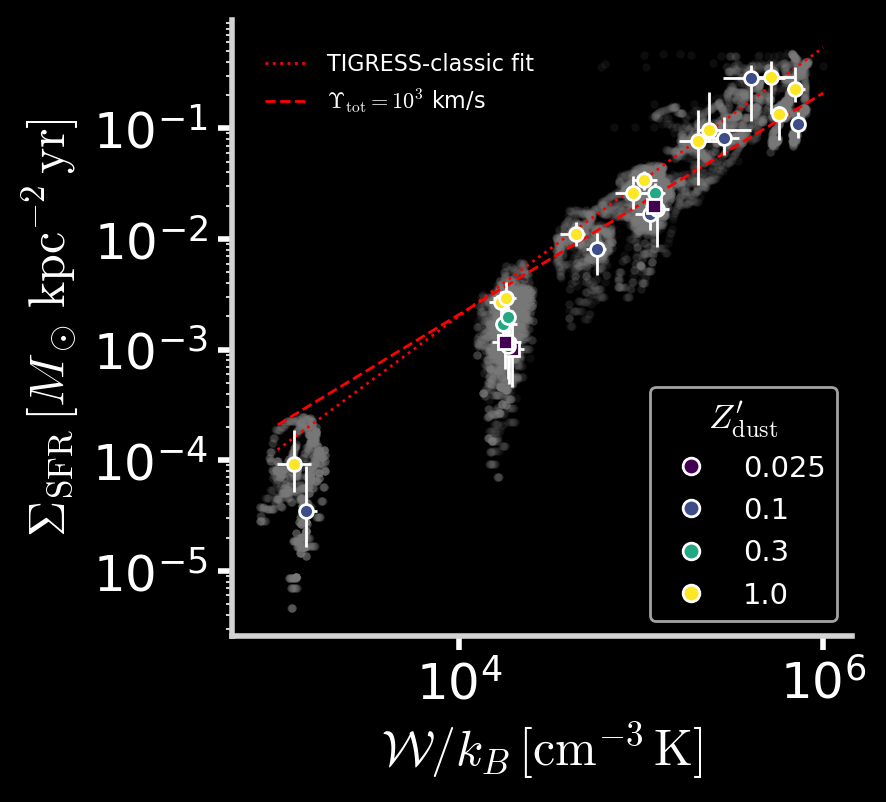

In [66]:
# Figure for weight and Ptot showing off parameter coverage
fig,ax = plt.subplots(1,1,figsize=(4,4))

# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1,x2,yf=['W','Zdust','sfr']

# exclude bad values from the fit
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
# linear regression
regr = regress(pt_logdf_good,x1=x1,x2=x2,yf=yf,fit_intercept=True)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model(regr,Zmin=Zmin,Zmax=0,Wmin=3,Wmax=6,dims=[x2,x1])    

# plot simulation data along with fitting result
plt.sca(ax)
# call plotting script
plot_fitting_points(qdset,model_dset,x1,yf,legend=4,colorbar=0,model=False)
# plot all data as grey dots
plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)    
W=model_dset.W.data
plt.plot(W,W*W_sfr_conv/1.e3,ls='--',color='r',lw=1)
plt.plot(W,W*W_sfr_conv/(10**3.86*(W)**(-0.212)),ls=':',color='r',lw=1)
leg1=plt.gca().get_legend()
custom_lines2 = [Line2D([0], [0], ls = ':', color='r', lw=1),
                 Line2D([0], [0], ls = '--', color='r', lw=1)]
leg2 = plt.legend(custom_lines2,
                  [r'TIGRESS-classic fit',r'$\Upsilon_{\rm tot}=10^3$ km/s'],
                  loc=2,borderpad=1,fontsize=8,frameon=False)
plt.gca().add_artist(leg1)
# # decorate axis
# fig.axes[-1].xaxis.set_ticks_position('top')
# fig.axes[-1].xaxis.set_label_position('top')
# plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
# fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')
# plt.xlim(1.e3,1.e6)
# plt.ylim(1.e-4,1)
# save figure
plt.savefig(os.path.join(outdir,'PRFM.png'),bbox_inches='tight')

In [67]:
import astropy.constants as ac
import astropy.units as au

In [68]:
W_sfr_conv=((ac.k_B*au.K/au.cm**3)/(au.km/au.s)).to('M_sun/kpc^2/yr').value

/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/astropy/units/format/generic.py:604: UnitsWarning: 'M_sun/kpc^2/yr' contains multiple slashes, which is discouraged by the FITS standard
  warnings.warn(


In [79]:
Zmin=-1
Zmax=0.
nZ=3

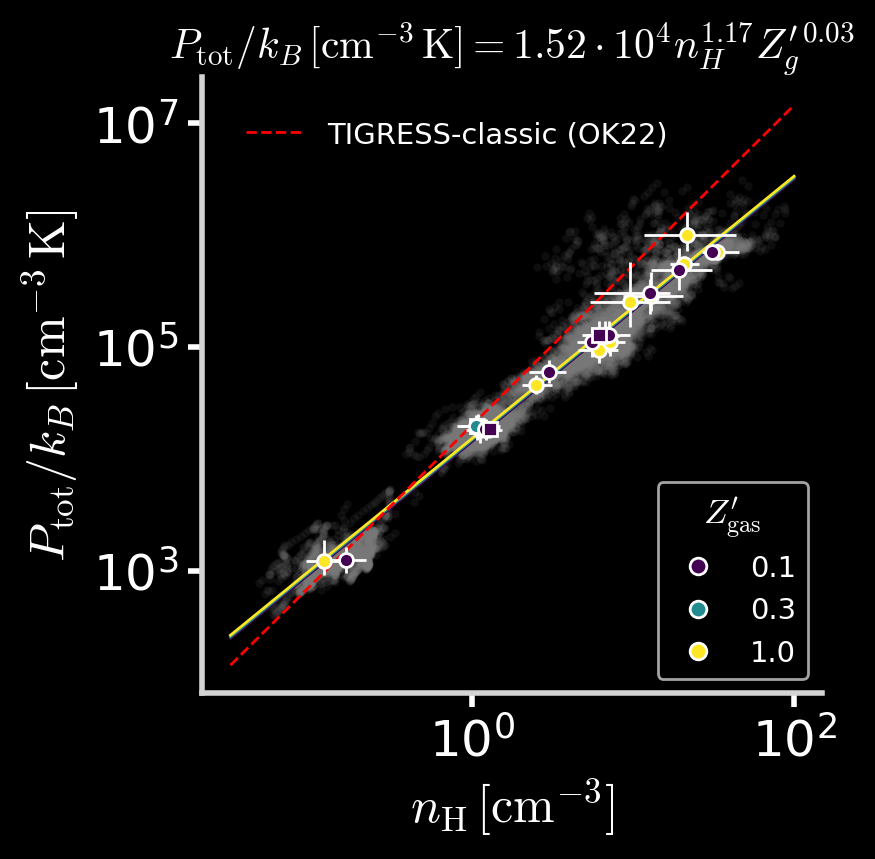

In [80]:
# Figure for the effective Equation of State (eEOS)
fig,axes = plt.subplots(1,1,figsize=(4,4))
axes = [axes]
# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1,x2,yf=['nH','Zgas','Ptot']

# exclude bad values from the fit
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
# linear regression
regr = regress(pt_logdf,x1=x1,x2=x2,yf=yf,fit_intercept=True)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model(regr,Zmin=Zmin,Zmax=Zmax,nZ=nZ,
                       Wmin=-1.5,Wmax=2,dims=[x2,x1])    

# plot simulation data along with fitting result
plt.sca(axes[0])
# write fitting result as the axis title
a=regr.coef_[0]
b=regr.coef_[1]
Y0=10**regr.intercept_
tit=labels[yf]+f'$={scifmt(Y0)} n_H^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$'
plt.title(tit,fontsize='small')

# call plotting script
plot_fitting_points(qdset,model_dset,x1,yf,legend=4,colorbar=0,model=regr)
# plot all data as grey dots
plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)    
# plt.xlabel('')

# plot residual compared with the fitting result
# plt.sca(axes[1])
# plot_fitting_points(qdset,model_dset,x1,yf,residual=True,model=regr)

# add reference line from the previous result (Ostriker & Kim 2022 Eq 27, Figure 14)
nH=model_dset.nH.data
plt.sca(axes[0])
plt.plot(nH,10**4.3*nH**1.43,ls='--',color='r',lw=1)
leg1=plt.gca().get_legend()
custom_lines2 = [Line2D([0], [0], ls = '--', color='r', lw=1)]
leg2 = plt.legend(custom_lines2,['TIGRESS-classic (OK22)'],loc=2,borderpad=1,fontsize='xx-small',frameon=False)
plt.gca().add_artist(leg1)

# decorate axis
# fig.axes[-1].xaxis.set_ticks_position('top')
# fig.axes[-1].xaxis.set_label_position('top')
# plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
# fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')

# save figure
plt.savefig(os.path.join(outdir,'eEOS_fit.png'),bbox_inches='tight')

In [88]:
# Figure for feedback yields (each component saved into each figure)
def plot_yield(yf):
    fig,axes = plt.subplots(1,1,figsize=(4,4))
    axes = [axes]

    # set field names for x-axes and yaxis
    x1,x2=['W','Zgas']

    # exclude bad values from the fit
    pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
    # linear regression
    regr = regress(pt_logdf_good,x1=x1,x2=x2,yf=yf,fit_intercept=True)
    # construct model
    model_dset = get_model(regr,Zmin=Zmin,Zmax=Zmax,nZ=nZ,
                           Wmin=Wmin,Wmax=Wmax)  

    # plot simulation data along with fitting result
    plt.sca(axes[0])

    # write fitting result as the axis title
    a=regr.coef_[0]
    b=regr.coef_[1]
    Y0=10**regr.intercept_*1.e4**a
    tit=labels[yf]+f'$={scifmt(Y0)} \\mathcal{{W}}_4^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$'
    plt.annotate(tit,(1.0,1.0),xycoords='axes fraction',
                 ha='right',va='bottom',fontsize='small')

    # call plotting script
    plot_fitting_points(qdset,model_dset,x1,yf,legend=1,colorbar=0,model=regr)
    # plot all data as grey dots
    plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
    plt.ylim((5.e1,2.e4))

    # plot residual compared with the fitting result
    # plt.sca(axes[1])
    # print(yf)
    # plot_fitting_points(qdset,model_dset,x1,yf,residual=True,model=regr)

    # decorate axis
    # fig.axes[-1].xaxis.set_ticks_position('top')
    # fig.axes[-1].xaxis.set_label_position('top')
    # plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
    # fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')
    
    # save figure
    plt.savefig(os.path.join(outdir,f'{yf}_fit.png'),bbox_inches='tight',dpi=200)

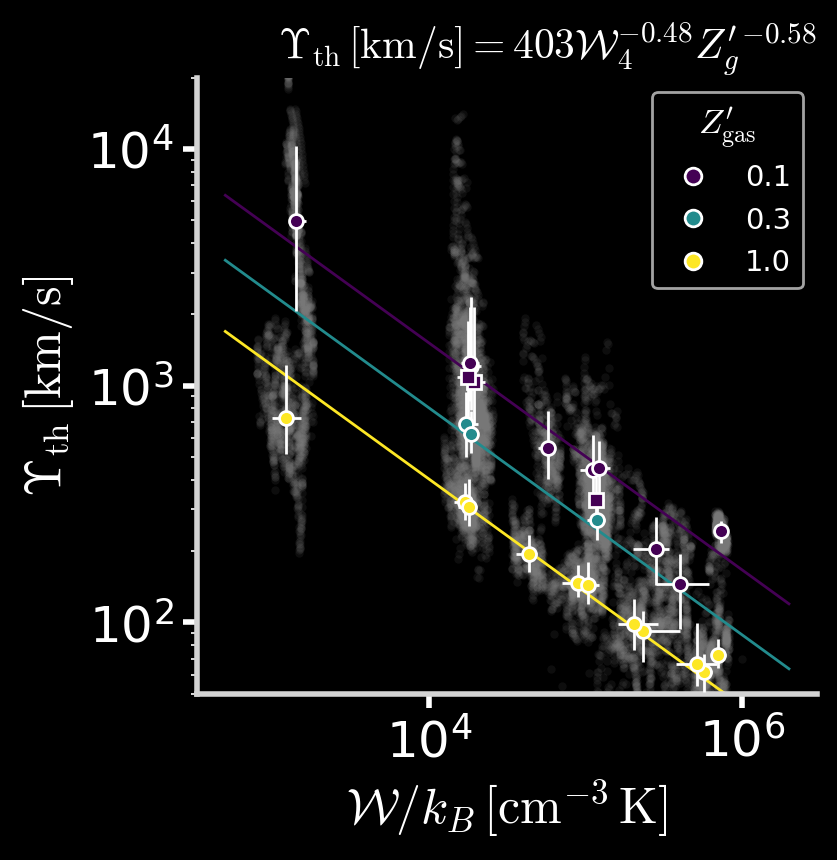

In [89]:
plot_yield('Yth')

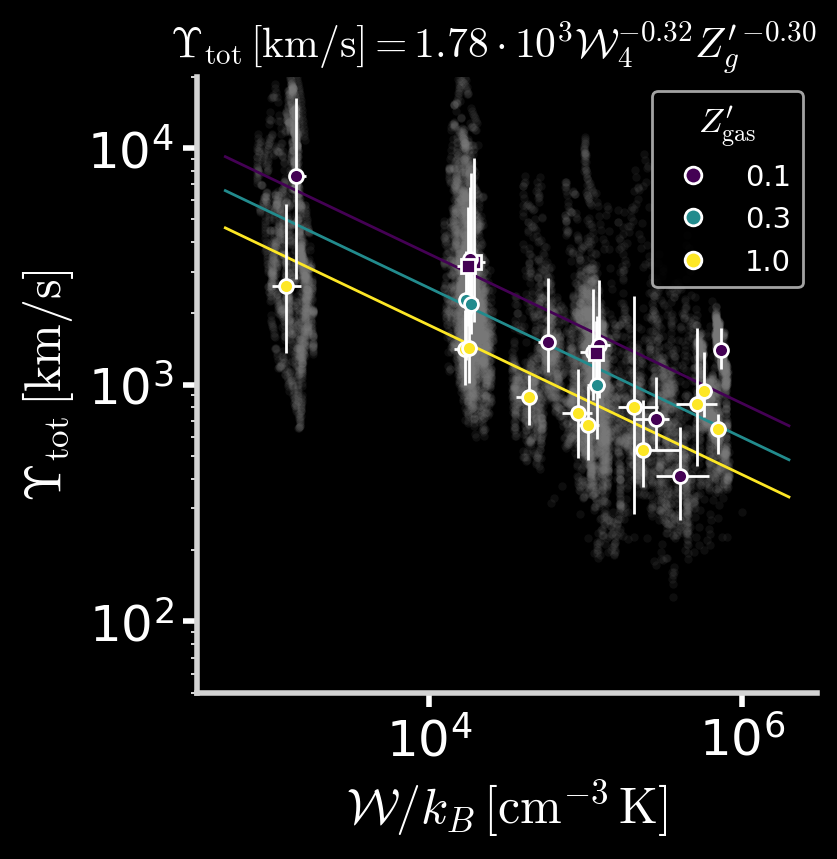

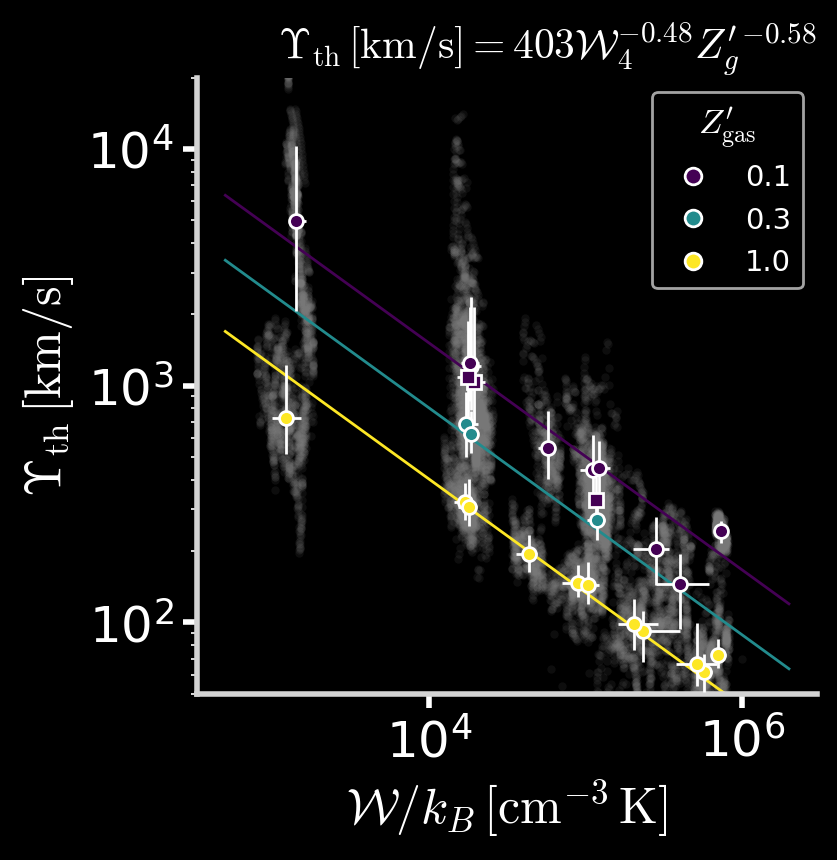

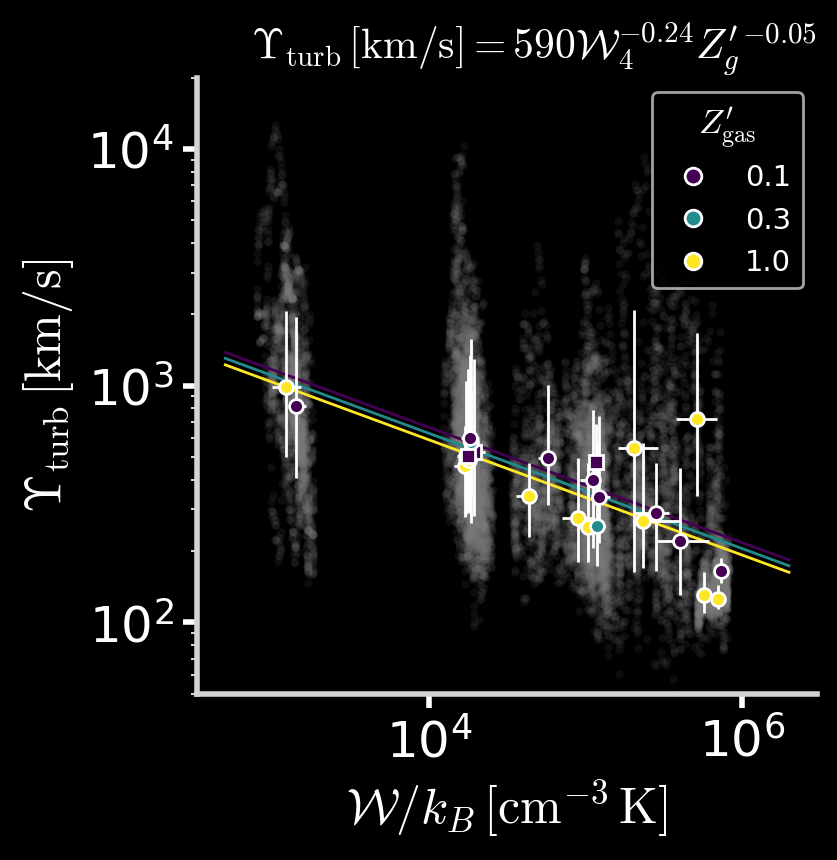

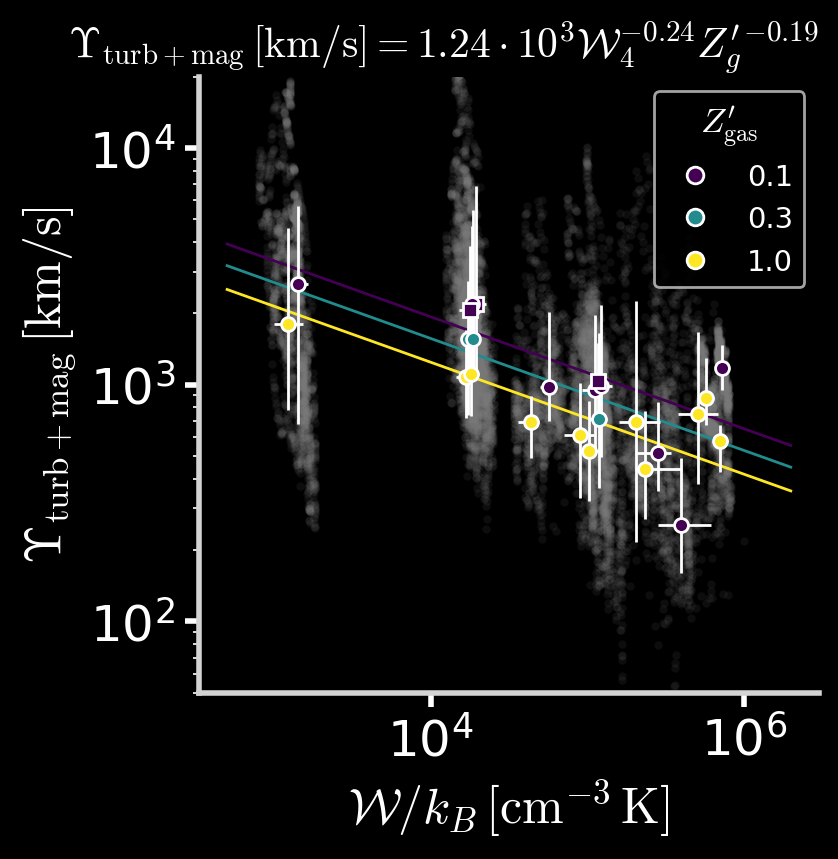

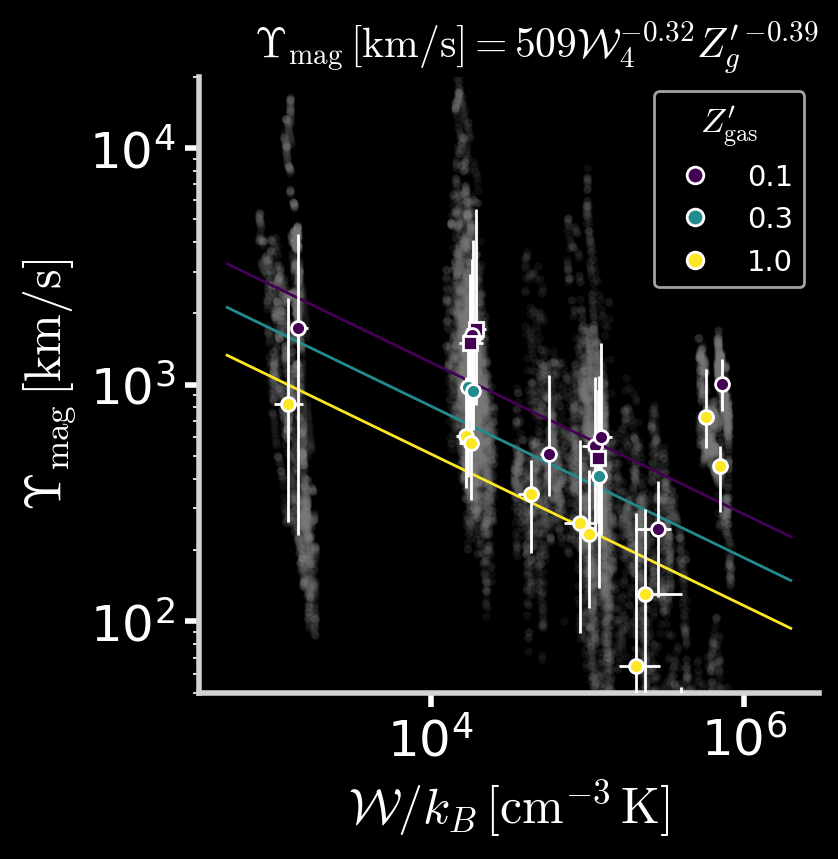

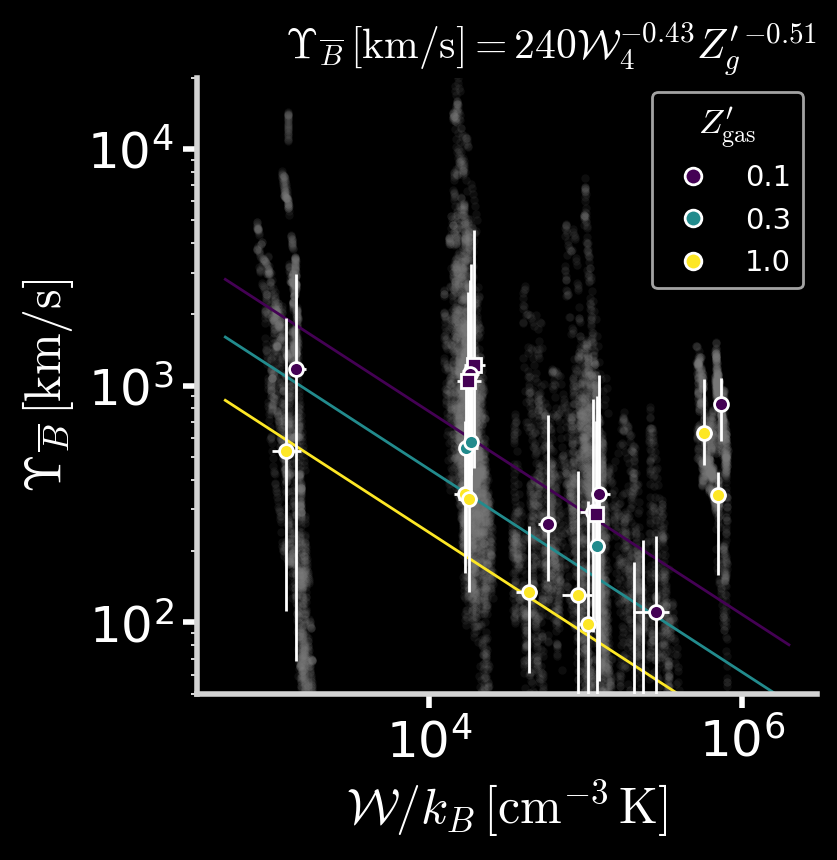

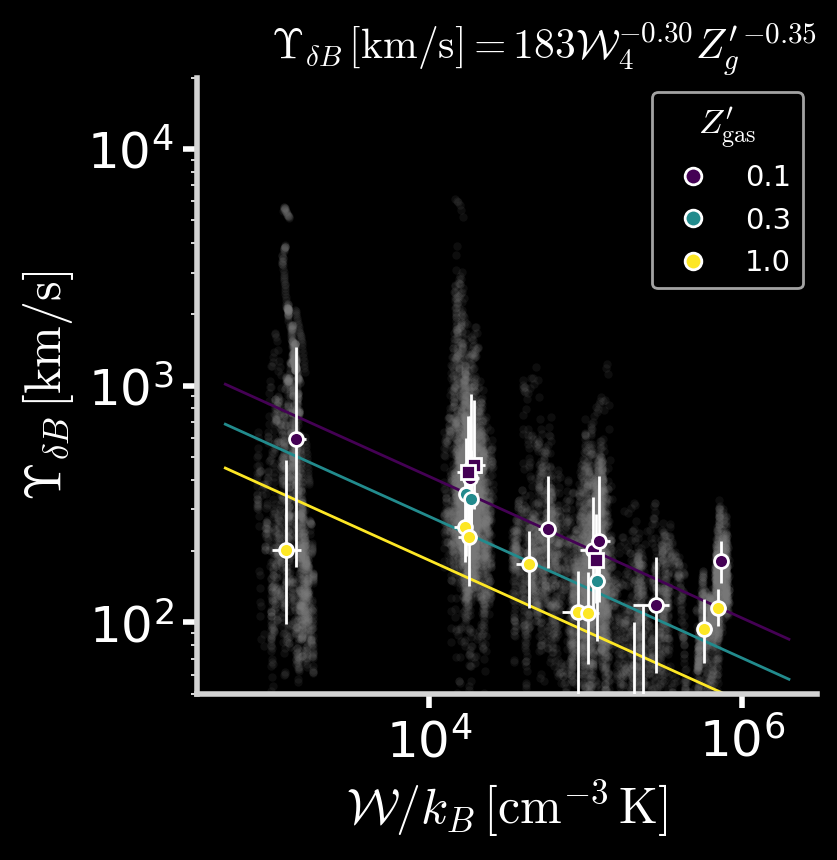

In [90]:
for yf in ['Ytot','Yth','Yturb','Ynonth','Ymag','oYmag','dYmag']:
    plot_yield(yf)

L1 : 0.25082139276345417
L2 : 0.3934944640160666


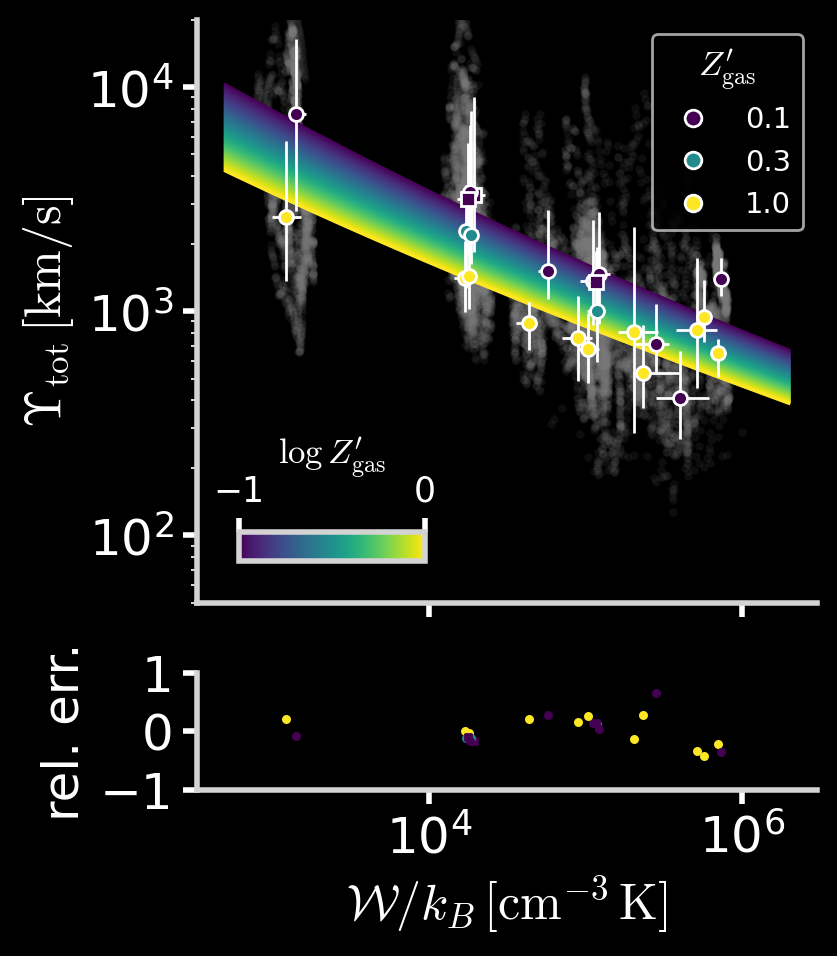

In [84]:
# Figure for total feedback yield compared with 
# the model based on thermal + nonthermal (turbulent+magnetic)
fig,axes = plt.subplots(2,1,sharex='col',figsize=(4,5),gridspec_kw=dict(height_ratios=[1,0.2]))

x1,x2=['W','Zgas']

# fitting for thermal feedback yield
yf = 'Yth'
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
regr = regress(pt_logdf_good,x1=x1,x2=x2,yf=yf,fit_intercept=True)
model_dset1 = get_model(regr,Zmin=Zmin,Zmax=Zmax,Wmin=Wmin,Wmax=Wmax)

# fitting for non-thermal feedback yield
yf = 'Ynonth'
pt_logdf_good = pt_logdf[~pt_logdf[[x1,x2,yf]].isin([np.nan, np.inf, -np.inf]).any(axis=1)].astype('float32')
regr = regress(pt_logdf_good,x1=x1,x2=x2,yf=yf,fit_intercept=True)
model_dset2 = get_model(regr,Zmin=Zmin,Zmax=Zmax,Wmin=Wmin,Wmax=Wmax,nZ=100,nW=100)

# get total feedback yield model by summing up two
model_dset = model_dset1+model_dset2

# plot results
plt.sca(axes[0])
plot_fitting_points(qdset,model_dset,x1,'Ytot',legend=1,colorbar=3)
plt.plot(pt_df[x1],pt_df['Ytot'],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
plt.ylim((5.e1,2.e4))

plt.sca(axes[1])
plot_fitting_points(qdset,model_dset,x1,'Ytot',residual=True)

axes[0].set_xlabel('')
fig.axes[-1].xaxis.set_ticks_position('top')
fig.axes[-1].xaxis.set_label_position('top')
plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')

plt.savefig(os.path.join(outdir,f'Ytot_fit2.png'),bbox_inches='tight')

In [93]:
qdset

<xarray.DataArray (name: 26, q: 5, variable: 94)>
[12220 values with dtype=float64]
Coordinates:
  * name      (name) object 'R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.ep...
  * variable  (variable) object 'Ptot' 'Ytot' 'Ptot_top' ... 'Zdust' 'PDE'
  * q         (q) object '16' '50' '84' 'mean' 'std'

(0.0, 1.0)

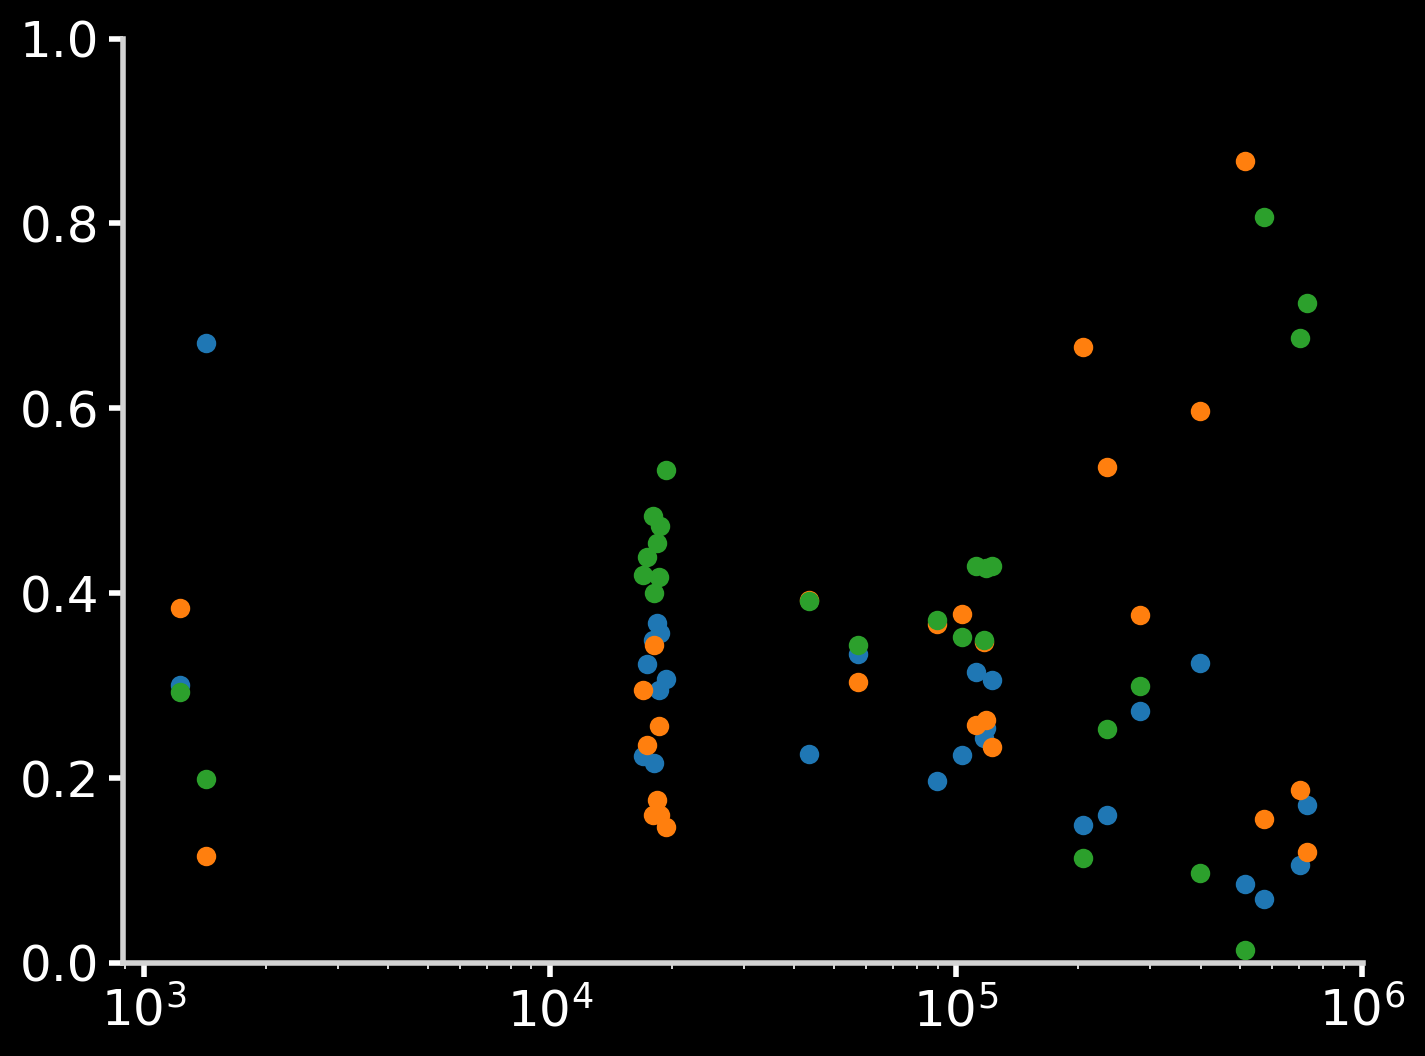

In [106]:
plt.plot(qdset.sel(variable='W',q='50'),
         qdset.sel(variable='Pth',q='50')/qdset.sel(variable='Ptot',q='50'),'o')
plt.plot(qdset.sel(variable='W',q='50'),
         qdset.sel(variable='Pturb',q='50')/qdset.sel(variable='Ptot',q='50'),'o')
plt.plot(qdset.sel(variable='W',q='50'),
         qdset.sel(variable='Pimag',q='50')/qdset.sel(variable='Ptot',q='50'),'o')
# plt.yscale('log')
plt.xscale('log')
plt.ylim(0,1)